# Predictive Maintenance Using LSTM and GRU on NASA Turbofan Engine Dataset
# Bonvie Fosam
## AndrewID: bfosam

Installing required packages. This is left commented out. Plese uncomment and run as needed.

In [2]:
#!pip install tensorflow
#!pip install scikit-learn
#!pip install torchinfo
#!pip install torch torchvision torchaudio

In [1]:
#Connecting notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading in the required libraries

In [3]:
#Load in all the required Libraries
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torchinfo import summary
from sklearn import preprocessing
import seaborn as sns
import pandas as pd
import numpy as np
import keras
import os

Loading in FD001 Training, Test, andd True Data. Please replace file path with your own if necessary.

In [4]:
#Loading in data and adding coluumn headers
sensors = ['sensor measurement ' + str(i) for i in range(1,22)]
headers = ['unit number', 'cycle', 'operational setting 1', 'operational setting 2', 'operational setting 3']
headers = headers+sensors

cols_to_drop = ['operational setting 3', 'sensor measurement 1', 'sensor measurement 5', 'sensor measurement 6', 'sensor measurement 10', 'sensor measurement 16', 'sensor measurement 18', 'sensor measurement 19']

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_FD001.txt', sep=r'\s+', header=None, names = headers)
train_df.drop(cols_to_drop, axis=1, inplace=True)

test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_FD001.txt', sep=r'\s+', header=None, names = headers)
test_df.drop(cols_to_drop, axis=1, inplace=True)

truth_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RUL_FD001.txt', sep=r'\s+', header=None)

## Data Processing

Processing Training Data

In [5]:
#Data Processing - Remaining Useful Life (small DF)
# Calculate the maximum cycle value for each engine (id) and store it in a new DataFrame (rul)
rul = pd.DataFrame(train_df.groupby('unit number')['cycle'].max())

# Rename the columns in the rul DataFrame
rul = rul.reset_index()
rul.columns = ['unit number', 'RUL']

#Data Processing - Training Data + RUL
# Merge the rul DataFrame with the original train_df based on the 'id' column
train_df = pd.merge(train_df, rul, on='unit number', how='left')

# Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
train_df['RUL'] = train_df['unit number'].values - 1 + train_df.groupby('unit number')['cycle'].transform(lambda s: max(s) - s)

##At this point the model is not normalized and it has a declining RUL for each cycle for each engine

In [6]:
# Generate label columns for training data -> Is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15

# Create a binary label ('label1') indicating if the engine will fail within w1 cycles (1) or not (0)
train_df['label1'] = (train_df['RUL'] <= w1).astype(int)

# Initialize a second label ('label2') as a copy of 'label1'
train_df['label2'] = train_df['label1'].copy()

# Update 'label2' to indicate if the engine will fail within w0 cycles (2) or not (0/1)
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
#train_df.drop(['RUL_x','RUL_y'], axis=1, inplace=True)

##At this point labels 1 and 2 are added and label i is 1 if within 30 days and label 2 is 2 if within 15 days of the end (failure)
##Still not yet normalized

In [7]:
#Now we need to normalize the Train Data Frame
scalar = MinMaxScaler()

#Create a normalized version of the 'cycle' column (e.g., 'cycle_norm') using the original 'cycle' values
train_df['cycle_norm'] = scalar.fit_transform(train_df[['cycle']])

#Select the columns to be normalized (all columns except 'id', 'cycle', 'RUL', 'label1', and 'label2')
cols_normalize = [col for col in train_df.columns if col not in ['unit number', 'cycle', 'RUL', 'label1', 'label2']]

#Apply MinMaxScaler to the selected columns and create a new normalized DataFrame
norm_train_df = pd.DataFrame(scalar.fit_transform(train_df[cols_normalize]),columns = cols_normalize, index = train_df.index)

#Join the normalized DataFrame with the original DataFrame (excluding normalized columns)
join_df = train_df[['unit number', 'cycle', 'RUL', 'label1', 'label2']].join(norm_train_df, lsuffix='_left', rsuffix='_right')
join_df = join_df.rename(columns={'unit number_left':'unit number'})

train_df = join_df[train_df.columns]

##At this point the training data is prepped for modeling - all columns are normalized except for the ones directed to leave out

Processing Test Data

In [8]:
#Now we will prepare the TEST DATA and Normalize it (remember wwe don't need to calculate the RUL because it is given to us)
test_df['cycle_norm'] = scalar.fit_transform(test_df[['cycle']])
norm_test_df = pd.DataFrame(scalar.fit_transform(test_df[cols_normalize]),columns = cols_normalize, index = test_df.index)
test_join_df = test_df[['unit number', 'cycle']].join(norm_test_df, lsuffix='_left', rsuffix='_right')
test_join_df = test_join_df.rename(columns={'unit number_left':'unit number'})

test_df =  test_join_df[test_df.columns]

#all columns are normalized except for the ones left out

In [9]:
#We now need to generate the column max for the test data

#Calculate the maximum cycle value for each engine (id) in the test data and store it in a new DataFrame (rul)
test_rul =  pd.DataFrame(test_df.groupby('unit number')['cycle'].max())

#Rename the columns in the rul DataFrame
test_rul = test_rul.reset_index()
test_rul.columns = ['unit number','max cycle']


#Merge the rul DataFrame with the original test_df based on the 'id' column
truth_df.columns = ['more']
truth_df['unit number'] = truth_df.index + 1
truth_df['max cycle'] = test_rul['max cycle'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)
test_df = pd.merge(test_df, truth_df, on='unit number', how='left')

#Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
test_df['RUL'] = test_df['max cycle'] - test_df['cycle']
test_df.drop('max cycle', axis=1, inplace=True)

#Now we have a total of the max cycles joined to our test data and all this is normalized

In [10]:
# Generate binary label columns (label1 and label2) based on RUL values and thresholds w0 and w1
# Similar to what you did in the train dataframe

w1 = 30
w0 = 15

test_df['label1'] = (test_df['RUL'] <= w1).astype(int)
test_df['label2'] = test_df['label1'].copy()
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

## Data Preparation for Model: reshaping features and target label

In [11]:
sequence_length = 50

#Function to reshape features into (samples, time steps, features)

def generate_sequences(id_df, sequence_length, feature_columns):
    """Generate sequences from a dataframe for a given id."""
    data_matrix = id_df[feature_columns].values
    num_elements = data_matrix.shape[0]

    sequences = []
    for start in range(num_elements - sequence_length + 1):
        end = start + sequence_length
        sequences.append(data_matrix[start:end])

    return np.array(sequences)

# Select feature columns for sequence generation (e.g., sensor readings, settings). This accomodates for the dropped columns
sensor_columns = ['sensor measurement '+ str(i) for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
sequence_columns = ['unit number', 'cycle', 'operational setting 1', 'operational setting 2'] + sensor_columns


# Generate sequences for all engine IDs
def generate_sequences_for_all_ids(df, sequence_length, feature_columns):
    sequences = []
    for engine_id in df['unit number'].unique():
        id_df = df[df['unit number'] == engine_id]
        sequences.append(generate_sequences(id_df, sequence_length, feature_columns))
    return np.concatenate(sequences, axis=0)

sequence_array = generate_sequences_for_all_ids(train_df, sequence_length, sequence_columns)

In [12]:
def generate_labels(id_df, sequence_length, label_column):
    """Generate labels for sequences based on the 'label_column'."""
    data_matrix = id_df[label_column].values
    num_elements = data_matrix.shape[0]

    # Ensure that labels are generated only for sequences that have enough data
    labels = []
    for start in range(0, num_elements - sequence_length + 1):
        end = start + sequence_length
        label = data_matrix[end-1]
        labels.append(label)  # Label corresponds to the last timestep in the sequence

    return np.array(labels)

sequence_length=50

label_column = 'label1'

label_1 = []
for engine_id in train_df['unit number'].unique():
        id_df = train_df[train_df['unit number'] == engine_id]
        label_1.extend(generate_labels(id_df, sequence_length, label_column))

label_array = np.array(label_1)

## LSTM Modeling

In [13]:
# Define the number of features and output units
if len(label_array.shape) == 1:
    nb_out = 1  # For binary classification
    label_array = label_array.reshape(-1, nb_out)
elif len(label_array.shape) == 2:
    nb_out = label_array.shape[1]
else:
    raise ValueError("Unexpected shape for label_array")

nb_features = sequence_array.shape[2]

# Create a Sequential model
model_LSTM = Sequential()

# Add LSTM layers and Dropout layers to the model
# Note: Limit the total number of model parameters to 10,000
# Your code here:
model_LSTM.add(LSTM(units=20, input_shape=(sequence_length, nb_features), return_sequences=True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units=10, return_sequences=False))
model_LSTM.add(Dropout(0.2))

# Add a Dense output layer with sigmoid activation
model_LSTM.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_LSTM.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 20)              │           3,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10)                  │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,371 (17.07 KB)

 Trainable params: 4,371 (17.07 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_LSTM = model_LSTM.fit(sequence_array, label_array, epochs=40, batch_size=32, validation_split=0.2,
                    callbacks = [
                        keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0.0001,
                        patience=5,
                        verbose=1,
                        mode='min'),
                         keras.callbacks.ModelCheckpoint(
                         '/content/drive/MyDrive/Colab Notebooks/best_model_lstm.keras',  # TODO: Replace with the file path to save the best model
                         monitor='val_loss',
                         save_best_only=True,
                         mode='min',
                         verbose=1)
                    ])

Epoch 1/40
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9392 - loss: 0.2750
Epoch 1: val_loss improved from inf to 0.00965, saving model to /content/drive/MyDrive/Colab Notebooks/best_model_lstm.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9393 - loss: 0.2745 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 2/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9590 - loss: 0.0983
Epoch 2: val_loss improved from 0.00965 to 0.00406, saving model to /content/drive/MyDrive/Colab Notebooks/best_model_lstm.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9590 - loss: 0.0983 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 3/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9597 - loss: 0.0912
Epoch 3: val_loss improved from 0.00406 to 0.00236, saving model to /content/drive/MyDrive/Colab Notebooks/best_model_lstm.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9597 - loss: 0.0912 - val_accuracy: 1.0000 - val_loss: 0.0024

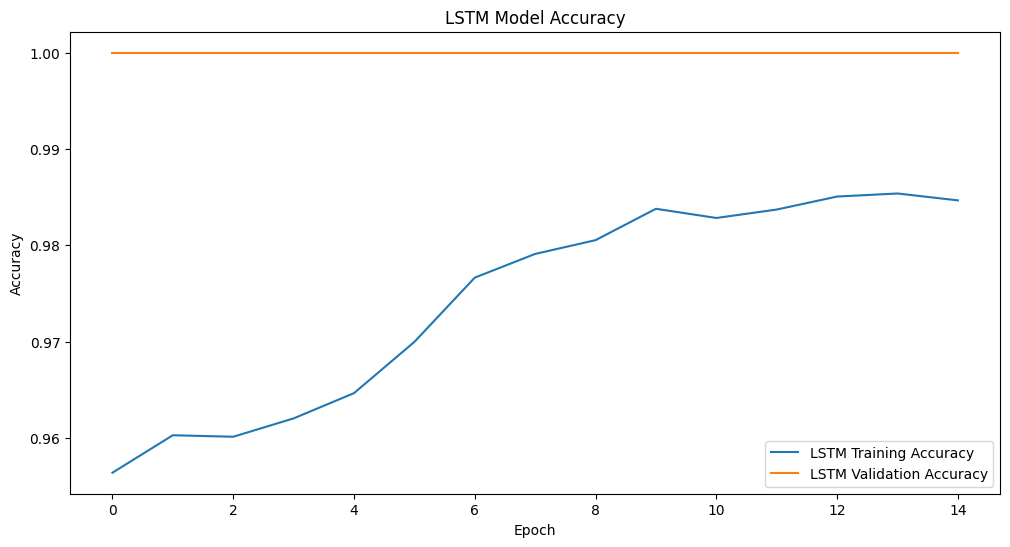

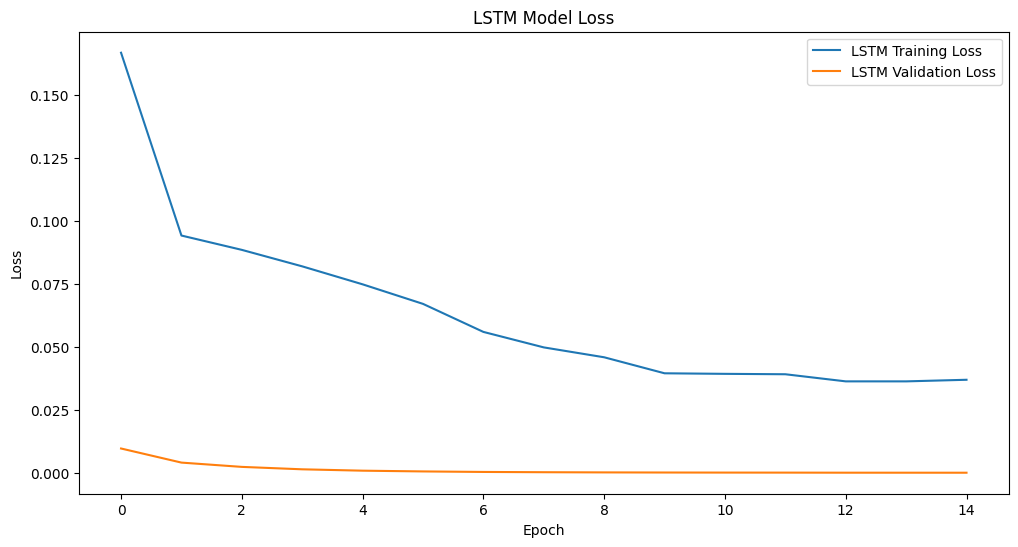

In [20]:
# Extract accuracy data
accuracy = history_LSTM.history['accuracy']
val_accuracy = history_LSTM.history['val_accuracy']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='LSTM Training Accuracy')
plt.plot(val_accuracy, label='LSTM Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')


# Save the plot to a file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/accuracy_plot.png')

# Display the plot
plt.show()
#----------------------------------------------------------------------------------
# Extract loss data
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(loss, label='LSTM Training Loss')
plt.plot(val_loss, label='LSTM Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')


# Save the plot to a file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/loss_plot.png')

# Display the plot
plt.show()

LSTM Model Evaluation

In [22]:
# Use the evaluate method to calculate the accuracy of the model on the training data
scores = model_LSTM.evaluate(sequence_array, label_array, verbose=0)
#print("Scores: " + str(scores))
print("Accuracy: " + str(history_LSTM.history['accuracy'][-1]))

# Use the predict method to make predictions on the training data
y_pred_raw_lstm = model_LSTM.predict(sequence_array)

#  Convert the predicted probabilities to class labels (e.g., using a threshold of 0.5)
y_pred_lstm = (y_pred_raw_lstm > 0.5).astype(int).flatten()
y_true_lstm = label_array

# Create a Pandas DataFrame from the predicted labels and save it to a CSV file
test_set = pd.DataFrame(y_pred_lstm, columns=['predicted labels'])
test_set.to_csv('/content/drive/MyDrive/Colab Notebooks/predicted_labels.csv', index=False)

Accuracy: 0.9846630692481995
492/492 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[15224    11]
 [  116   380]]
precision =  0.9718670076726342 
 recall =  0.7661290322580645


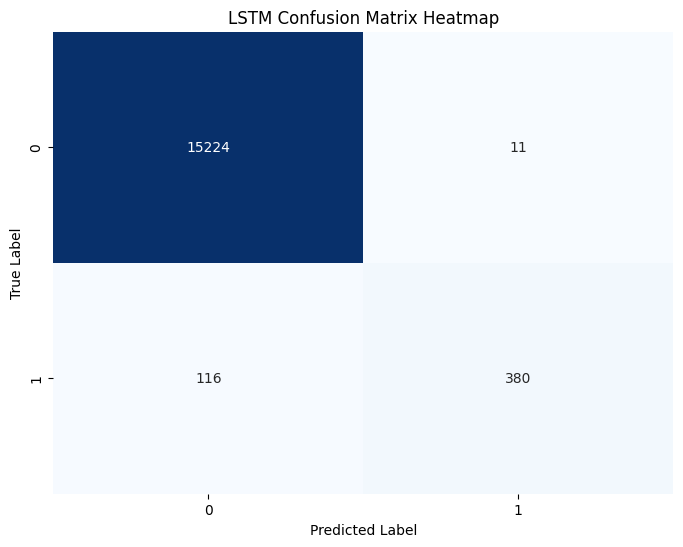

In [23]:
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
# TODO: Compute the confusion matrix using confusion_matrix from sklearn.metrics
cm_LSTM = confusion_matrix(y_true_lstm, y_pred_lstm)
print(cm_LSTM)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_LSTM, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels
plt.title('LSTM Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Calculate the precision using precision_score and recall using recall_score from sklearn.metrics
precision_LSTM = precision_score(y_true_lstm, y_pred_lstm)
recall_LSTM = recall_score(y_true_lstm, y_pred_lstm)
print( 'precision = ', precision_LSTM, '\n', 'recall = ', recall_LSTM)

In [24]:
results_df = pd.DataFrame([[history_LSTM.history['accuracy'][-1],precision_LSTM,recall_LSTM],
                          [0.94, 0.952381, 0.8]],
                         columns = ['Accuracy', 'Precision', 'Recall'],
                         index = ['LSTM',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall
LSTM,0.984663,0.971867,0.766129
Template Best Model,0.940000,0.952381,0.800000


LSTM Model Evaluation on Validation Set

In [25]:
# Pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['unit number']==id][sequence_columns].values[-sequence_length:] if len(test_df[test_df['unit number']==id]) >= sequence_length
                       else np.zeros((sequence_length, len(sequence_columns)))
                       for id in test_df['unit number'].unique()]

# Convert to numpy array and ensure float32 data type
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

#Pick the labels for the selected sequences
# Replace with code to select labels for sequences with length >= sequence_length
#y_mask = [len(test_df[test_df['unit number']==id]) >= sequence_length for id in test_df['unit number'].unique()]

 # Replace with code to select labels for the selected sequences
#label_array_test_last = test_df.groupby('unit number')['label1'].nth(-1)[y_mask].values
label_array_test_last = test_df.groupby('unit number')['label1'].nth(-1).values

# Reshape and ensure float32 data type
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)

Accuracy: 0.699999988079071
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  8]
 [22  3]]
Precision:  0.2727272727272727 
 Recall:  0.12 
 F1-score: 0.16666666666666666


Text(0.5, 1.0, 'True vs Predicted Binary Classification')

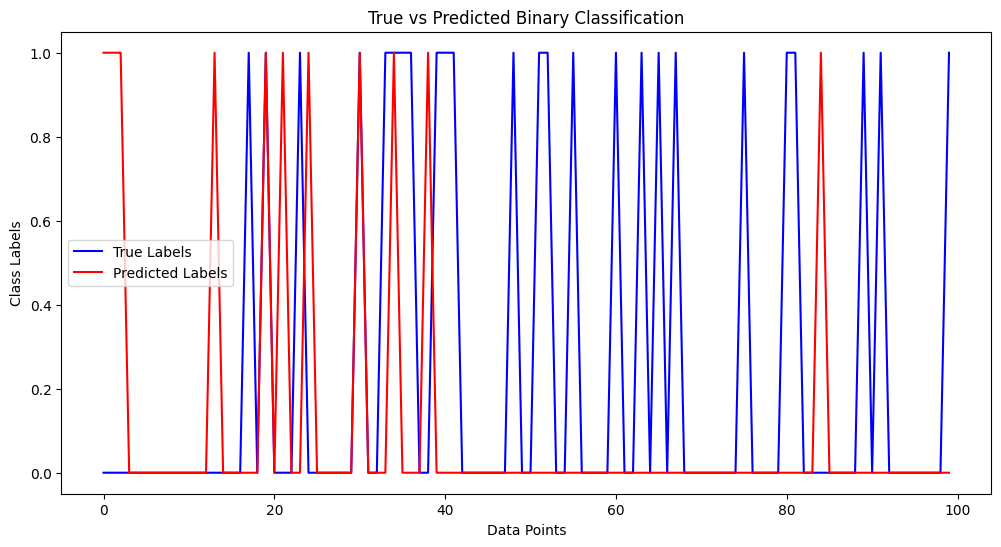

In [26]:
# Load the saved model if it exists

# Replace with code to load the saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/best_model_lstm.keras'
if os.path.isfile(model_path):
    # Use estimator variable to load the model
    estimator = load_model(model_path)
else:
    print("Model not found at the specified path.")
    estimator = None

# Evaluate the model on the test data
if estimator is not None:
  min_samples = min(seq_array_test_last.shape[0], label_array_test_last.shape[0])
  #scores_test = estimator.evaluate(seq_array_test_last[:min_samples], label_array_test_last[:min_samples], verbose=0)
  scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=0)
  print('Accuracy: {}'.format(scores_test[1]))
else:
  print("Cannot evaluate the model as it was not loaded.")


if estimator is not None:
  y_pred_test = estimator.predict(seq_array_test_last)
  y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

  # Only include predictions for samples that have labels
  y_pred_test = y_pred_test[:len(label_array_test_last)]

  y_true_test = label_array_test_last

  # TODO: Create pandas dataframe of y_pred_test and save predictions to CSV file
  test_set = pd.DataFrame(y_pred_test, columns=['predicted labels'])
  test_set.to_csv('/content/drive/MyDrive/Colab Notebooks/predicted_labels_test.csv', index=False)

  # TODO: Compute confusion matrix
  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  cm = confusion_matrix(label_array_test_last, y_pred_test)
  print(cm)

  # TODO: Compute precision, recall, and F1-score
  precision_test = precision_score(label_array_test_last, y_pred_test)
  recall_test = recall_score(label_array_test_last, y_pred_test)
  f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
  print('Precision: ', precision_test, '\n', 'Recall: ', recall_test, '\n', 'F1-score:', f1_test)
else:
  print("Cannot make predictions as the model was not loaded.")

#Plot predicted and actual data for visual verification
plt.figure(figsize=(12, 6))
plt.plot(label_array_test_last, label='Actual', color='blue')
plt.plot(y_pred_test, label='Predicted', color='red')
plt.legend(['True Labels', 'Predicted Labels'])
plt.xlabel('Data Points')
plt.ylabel('Class Labels')
plt.title('True vs Predicted Binary Classification')

In [27]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.70,0.272727,0.12,0.166667
Template Best Model,0.94,0.952381,0.80,0.869565


## GRU Modeling

In [28]:
# Define the number of features and output units
if len(label_array.shape) == 1:
    nb_out = 1  # For binary classification
    label_array = label_array.reshape(-1, nb_out)
elif len(label_array.shape) == 2:
    nb_out = label_array.shape[1]
else:
    raise ValueError("Unexpected shape for label_array")

nb_features = sequence_array.shape[2]

# Create a Sequential model
model_gru = Sequential()

# Add LSTM layers and Dropout layers to the model
# Note: Limit the total number of model parameters to 10,000
# Your code here:
model_gru.add(GRU(units=20, input_shape=(sequence_length, nb_features), return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(units=10, return_sequences=False))
model_gru.add(Dropout(0.2))

# Add a Dense output layer with sigmoid activation
model_gru.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_gru.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50, 20)              │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 10)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,371 (13.17 KB)

 Trainable params: 3,371 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history_gru = model_gru.fit(sequence_array, label_array, epochs=40, batch_size=32, validation_split=0.2,
                    callbacks = [
                        keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0.0001,
                        patience=5,
                        verbose=1,
                        mode='min'),
                         keras.callbacks.ModelCheckpoint(
                         '/content/drive/MyDrive/Colab Notebooks/best_model_gru.keras',  # TODO: Replace with the file path to save the best model
                         monitor='val_loss',
                         save_best_only=True,
                         mode='min',
                         verbose=1)
                    ])

Epoch 1/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9478 - loss: 0.1922
Epoch 1: val_loss improved from inf to 0.00752, saving model to /content/drive/MyDrive/Colab Notebooks/best_model_gru.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.9478 - loss: 0.1921 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 2/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9601 - loss: 0.0986
Epoch 2: val_loss improved from 0.00752 to 0.00298, saving model to /content/drive/MyDrive/Colab Notebooks/best_model_gru.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.9601 - loss: 0.0986 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/40
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9672 - loss: 0.0769
Epoch 3: val_loss improved from 0.00298 to 0.00158, saving model to /content/drive/MyDrive/Colab Notebooks/best_model_gru.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.9672 - loss: 0.0769 - val_accuracy: 1.0000 - val_loss: 0.0016
Ep

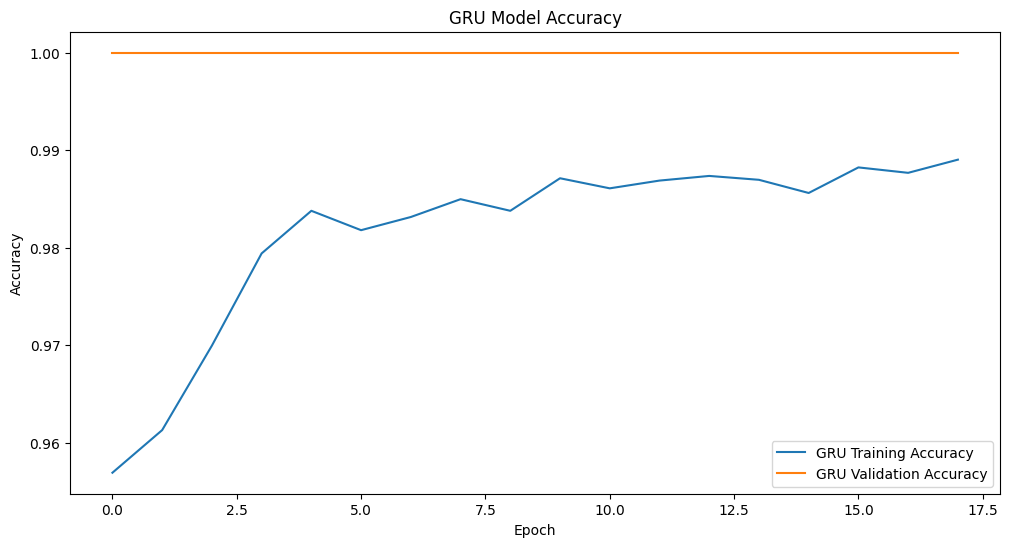

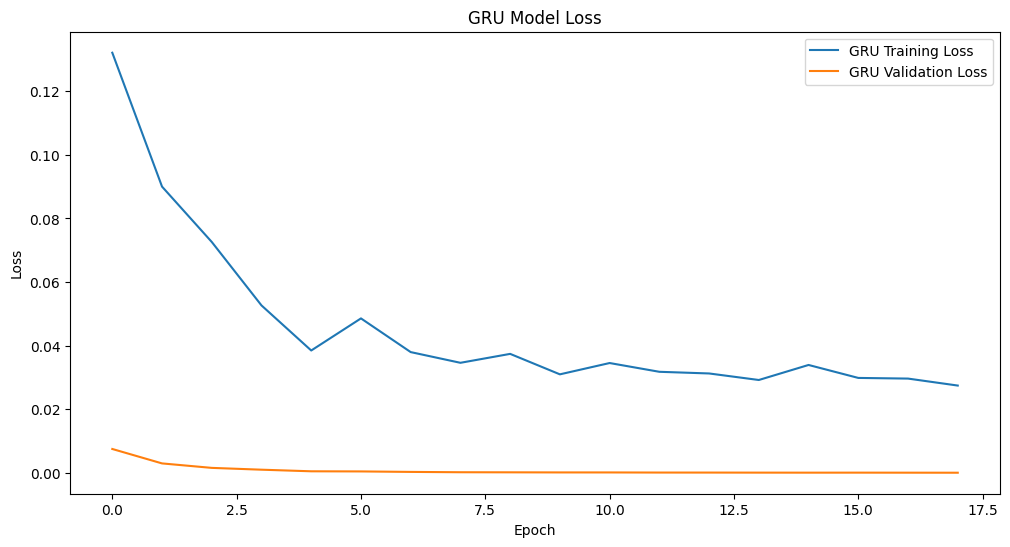

In [30]:
# Extract accuracy data
accuracy = history_gru.history['accuracy']
val_accuracy = history_gru.history['val_accuracy']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='GRU Training Accuracy')
plt.plot(val_accuracy, label='GRU Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')


# Save the plot to a file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/accuracy_plot_gru.png')

# Display the plot
plt.show()
#----------------------------------------------------------------------------------
# Extract loss data
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(loss, label='GRU Training Loss')
plt.plot(val_loss, label='GRU Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')


# Save the plot to a file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/loss_plot_gru.png')

# Display the plot
plt.show()

In [31]:
# Use the evaluate method to calculate the accuracy of the model on the training data
scores = model_gru.evaluate(sequence_array, label_array, verbose=0)
#print("Scores: " + str(scores))
print("Accuracy: " + str(history_gru.history['accuracy'][-1]))

# Use the predict method to make predictions on the training data
y_pred_raw_gru = model_gru.predict(sequence_array)

#  Convert the predicted probabilities to class labels (e.g., using a threshold of 0.5)
y_pred_gru = (y_pred_raw_gru > 0.5).astype(int).flatten()
y_true_gru = label_array

# Create a Pandas DataFrame from the predicted labels and save it to a CSV file
test_set = pd.DataFrame(y_pred_gru, columns=['predicted labels'])
test_set.to_csv('/content/drive/MyDrive/Colab Notebooks/predicted_labels_gru.csv', index=False)

Accuracy: 0.9890336990356445


492/492 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[15092   143]
 [   15   481]]
precision =  0.7708333333333334 
 recall =  0.969758064516129


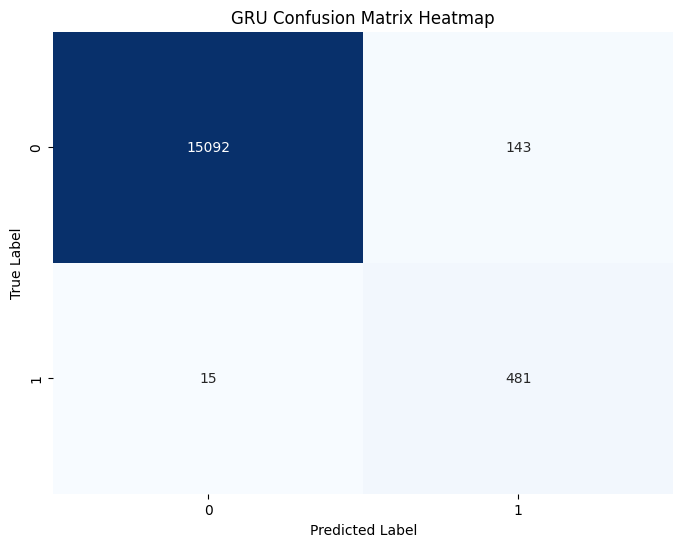

In [32]:
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
# TODO: Compute the confusion matrix using confusion_matrix from sklearn.metrics
cm_gru = confusion_matrix(y_true_gru, y_pred_gru)
print(cm_gru)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_gru, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels
plt.title('GRU Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Calculate the precision using precision_score and recall using recall_score from sklearn.metrics
precision_gru = precision_score(y_true_gru, y_pred_gru)
recall_gru = recall_score(y_true_gru, y_pred_gru)
print( 'precision = ', precision_gru, '\n', 'recall = ', recall_gru)

In [34]:
results_df = pd.DataFrame([[history_gru.history['accuracy'][-1],precision_gru,recall_gru],
                          [0.94, 0.952381, 0.8]],
                         columns = ['Accuracy', 'Precision', 'Recall'],
                         index = ['GRU',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall
GRU,0.989034,0.770833,0.969758
Template Best Model,0.940000,0.952381,0.800000


GRU Model Evaluation on Validation Set

In [35]:
# Pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['unit number']==id][sequence_columns].values[-sequence_length:] if len(test_df[test_df['unit number']==id]) >= sequence_length
                       else np.zeros((sequence_length, len(sequence_columns)))
                       for id in test_df['unit number'].unique()]

# Convert to numpy array and ensure float32 data type
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

#Pick the labels for the selected sequences
# Replace with code to select labels for sequences with length >= sequence_length
#y_mask = [len(test_df[test_df['unit number']==id]) >= sequence_length for id in test_df['unit number'].unique()]

 # Replace with code to select labels for the selected sequences
label_array_test_last = test_df.groupby('unit number')['label1'].nth(-1).values

# Reshape and ensure float32 data type
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)

Accuracy: 0.7799999713897705
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[73  2]
 [20  5]]
Precision:  0.7142857142857143 
 Recall:  0.2 
 F1-score: 0.3125


Text(0.5, 1.0, 'True vs Predicted Binary Classification')

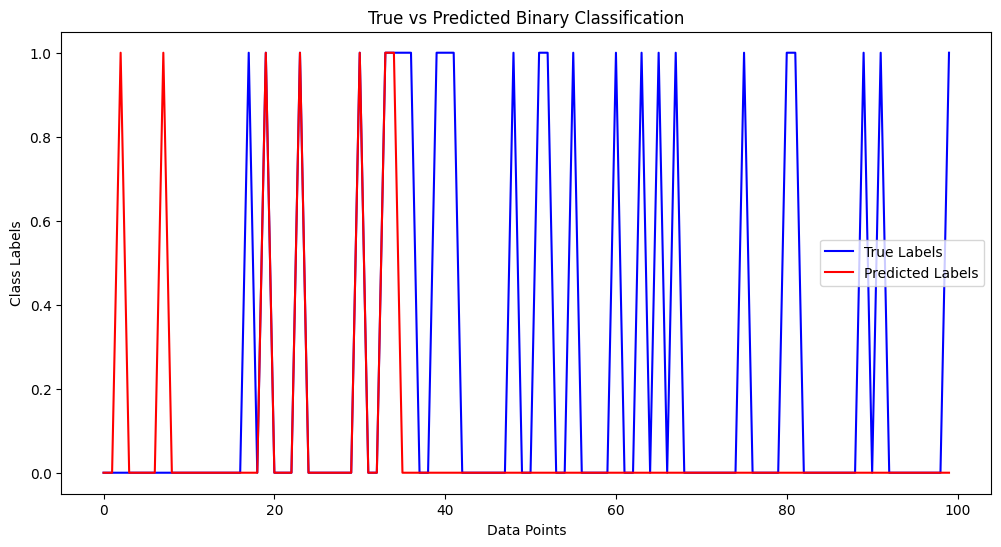

In [36]:
# Load the saved model if it exists

# Replace with code to load the saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/best_model_gru.keras'
if os.path.isfile(model_path):
    # Use estimator variable to load the model
    estimator = load_model(model_path)
else:
    print("Model not found at the specified path.")
    estimator = None

# Evaluate the model on the test data
if estimator is not None:
  min_samples = min(seq_array_test_last.shape[0], label_array_test_last.shape[0])
  #scores_test = estimator.evaluate(seq_array_test_last[:min_samples], label_array_test_last[:min_samples], verbose=0)
  scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=0)
  print('Accuracy: {}'.format(scores_test[1]))
else:
  print("Cannot evaluate the model as it was not loaded.")


if estimator is not None:
  y_pred_test = estimator.predict(seq_array_test_last)
  y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

  # Only include predictions for samples that have labels
  y_pred_test = y_pred_test[:len(label_array_test_last)]

  y_true_test = label_array_test_last

  # TODO: Create pandas dataframe of y_pred_test and save predictions to CSV file
  test_set = pd.DataFrame(y_pred_test, columns=['predicted labels'])
  test_set.to_csv('/content/drive/MyDrive/Colab Notebooks/predicted_labels_test.csv', index=False)

  # TODO: Compute confusion matrix
  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  cm = confusion_matrix(label_array_test_last, y_pred_test)
  print(cm)

  # TODO: Compute precision, recall, and F1-score
  precision_test = precision_score(label_array_test_last, y_pred_test)
  recall_test = recall_score(label_array_test_last, y_pred_test)
  f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
  print('Precision: ', precision_test, '\n', 'Recall: ', recall_test, '\n', 'F1-score:', f1_test)
else:
  print("Cannot make predictions as the model was not loaded.")

#Plot predicted and actual data for visual verification
plt.figure(figsize=(12, 6))
plt.plot(label_array_test_last, label='Actual', color='blue')
plt.plot(y_pred_test, label='Predicted', color='red')
plt.legend(['True Labels', 'Predicted Labels'])
plt.xlabel('Data Points')
plt.ylabel('Class Labels')
plt.title('True vs Predicted Binary Classification')

In [38]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['GRU',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
GRU,0.78,0.714286,0.2,0.312500
Template Best Model,0.94,0.952381,0.8,0.869565
